In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [8]:
def addDegreeConstrs(model, x, edges, nodes):
    model.addConstrs((sum([x[k, j] for (k, j) in edges if k == i] + [x[j, k] for (j, k) in edges if k == i]) == 2 for i in nodes), name="degree constraints")

In [3]:
def addSubtourConstrs(model, x, edges, S: list):
    model.addConstr(sum([x[i, j] for (i, j) in edges if i in S and j not in S] 
                      + [x[i, j] for (i, j) in edges if i not in S and j in S]) >= 2, name="subtour constraints for" + str(S))

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def plotGraph(edges, weight, x):
    # x[i, j] are the variables of the LP associated with the graph
    G = nx.Graph()
    
    G.add_weighted_edges_from([(i, j, weight[i][j]) for (i, j) in edges]) 
    
    edge_colors = ['red' if x[i, j].X == 1 else 'blue' for (i, j, w) in G.edges(data = True)]
    
    pos = nx.circular_layout(G)  
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, width=2, node_size=500)

    edge_labels = {edge: x[edge].X for edge in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")
    
    plt.show()

/home/ndntam/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 1. Real data coming from an older version of the universities in the South-Eastern Conference (SEC).

In [5]:
schools = ["Al", "Au", "Fl", "Ga", "Ky", "LS", "MS", "OM", "Tn", "Vb"]
schoolIndex = {school: idx for idx, school in enumerate(schools)}
nschools = len(schools)
dist = [[0, 160, 444, 272, 455, 322, 88, 172, 312, 238],
[0, 0, 297, 200, 521, 419, 186, 279, 362, 350],
[0, 0, 0, 335, 714, 604, 523, 608, 526, 584],
[0, 0, 0, 0, 397, 594, 351, 396, 208, 295],
[0, 0, 0, 0, 0, 761, 501, 477, 189, 217],
[0, 0, 0, 0, 0, 0, 286, 296, 634, 544],
[0, 0, 0, 0, 0, 0, 0, 110, 384, 266],
[0, 0, 0, 0, 0, 0, 0, 0, 404, 248],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 178],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
dist = np.transpose(dist) + dist

In [12]:
sec = gp.Model("SEC")
good = [(i, j) for i in range(nschools) for j in range(nschools) if i < j and dist[i][j] < 500]
bad = [(i, j) for i in range(nschools) for j in range(nschools) if i < j and dist[i][j] >= 500]
xSEC = sec.addVars(good, vtype = GRB.CONTINUOUS, name = "x",
               ub = 1, lb = 0, obj = {(i, j): dist[i][j] for (i, j) in good})

In [13]:
addDegreeConstrs(sec, xSEC, good, range(nschools))

In [14]:
sec.update()
sec.getObjective()
[(sec.getRow(constr), constr.getAttr('Sense'), constr.getAttr('RHS')) for constr in sec.getConstrs()]

[(<gurobi.LinExpr: x[0,1] + x[0,2] + x[0,3] + x[0,4] + x[0,5] + x[0,6] + x[0,7] + x[0,8] + x[0,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,1] + x[1,2] + x[1,3] + x[1,5] + x[1,6] + x[1,7] + x[1,8] + x[1,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,2] + x[1,2] + x[2,3]>, '=', 2.0),
 (<gurobi.LinExpr: x[0,3] + x[1,3] + x[2,3] + x[3,4] + x[3,6] + x[3,7] + x[3,8] + x[3,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,4] + x[3,4] + x[4,7] + x[4,8] + x[4,9]>, '=', 2.0),
 (<gurobi.LinExpr: x[0,5] + x[1,5] + x[5,6] + x[5,7]>, '=', 2.0),
 (<gurobi.LinExpr: x[0,6] + x[1,6] + x[3,6] + x[5,6] + x[6,7] + x[6,8] + x[6,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,7] + x[1,7] + x[3,7] + x[4,7] + x[5,7] + x[6,7] + x[7,8] + x[7,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,8] + x[1,8] + x[3,8] + x[4,8] + x[6,8] + x[7,8] + x[8,9]>,
  '=',
  2.0),
 (<gurobi.LinExpr: x[0,9] + x[1,9] + x[3,9] + x[4,9] + x[6,9] + x[7,9] + x[8,9]>,
  '=',
  2.0)]

In [15]:
sec.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 33 columns and 66 nonzeros
Model fingerprint: 0x2253c0d8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.01s
Presolved: 10 rows, 33 columns, 66 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5440000e+03   1.100000e+01   0.000000e+00      0s
       8    2.2320000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.232000000e+03


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11 rows, 33 columns and 79 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2320000e+03   2.000000e+00   0.000000e+00      0s
       2    2.2925000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.292500000e+03


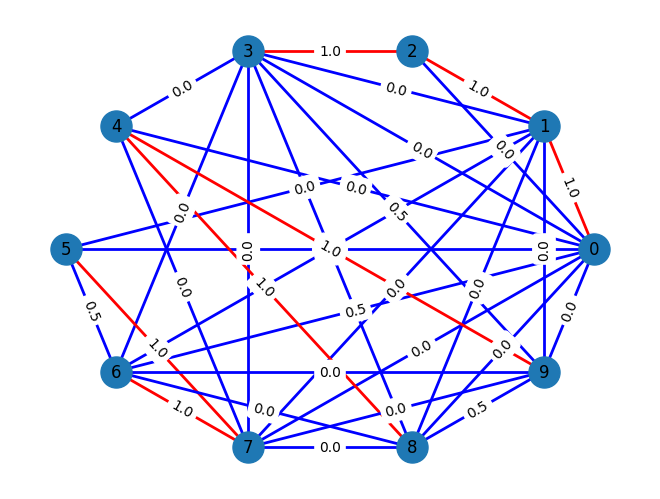

In [17]:
addSubtourConstrs(sec, xSEC, good, [1, 2, 3])
sec.optimize()
plotGraph(good, dist, xSEC)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12 rows, 33 columns and 92 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2925000e+03   1.000000e+00   0.000000e+00      0s
       3    2.3240000e+03   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.324000000e+03


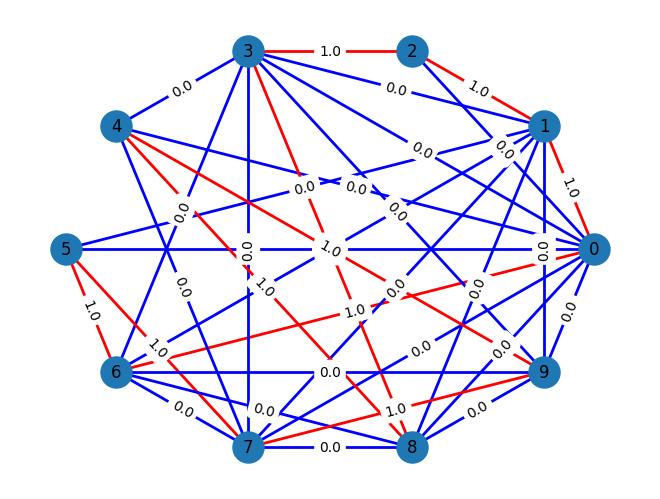

In [20]:
addSubtourConstrs(sec, xSEC, good, [4, 8, 9])
sec.optimize()
plotGraph(good, dist, xSEC)

# 2. Synthetic data